<a href="https://colab.research.google.com/github/kiran-pyt/ERA1S5/blob/main/S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn #Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
import torch.nn.functional as F  # Contains activation functions and loss functions
import torch.optim as optim # Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss)
from torchvision import datasets, transforms #Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here.
from torch.utils.data import Dataset, TensorDataset #Base dataset class for PyTorch.
from torch.utils.data import DataLoader #Creates a Python iteralbe over a dataset (created with torch.utils.data.Dataset).
from matplotlib import pyplot as plt  # for ploting
import numpy as np                    # For calculating the tesnors 
#!pip install torchsummary
from torchsummary import summary      # TO know the summary of the developed model

CODE BLOCK: 2

In [ ]:
# CUDA?
use_cuda = torch.cuda.is_available()                 # used check whether the GPU is avilable or not
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

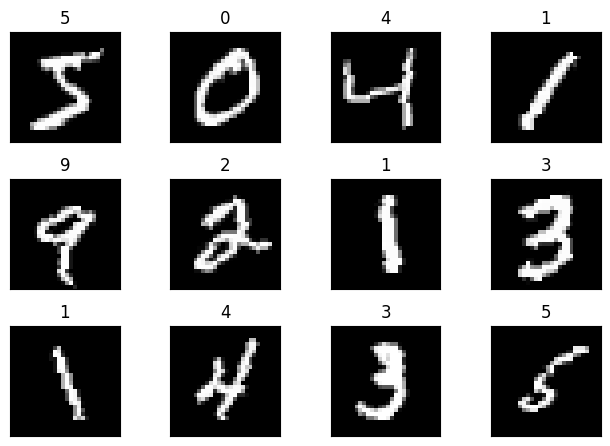

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 10

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
#criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.6883 Batch_id=117 Accuracy=43.04: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.4543, Accuracy: 8567/10000 (85.67%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2454 Batch_id=117 Accuracy=92.58: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s]


Test set: Average loss: 0.1390, Accuracy: 9542/10000 (95.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1789 Batch_id=117 Accuracy=96.04: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]


Test set: Average loss: 0.1011, Accuracy: 9663/10000 (96.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1695 Batch_id=117 Accuracy=96.92: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


Test set: Average loss: 0.0736, Accuracy: 9752/10000 (97.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1396 Batch_id=117 Accuracy=97.30: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


Test set: Average loss: 0.0625, Accuracy: 9798/10000 (97.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1328 Batch_id=117 Accuracy=97.66: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0662, Accuracy: 9779/10000 (97.79%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1231 Batch_id=117 Accuracy=98.00: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.0596, Accuracy: 9805/10000 (98.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1263 Batch_id=117 Accuracy=98.07: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0577, Accuracy: 9826/10000 (98.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1236 Batch_id=117 Accuracy=98.11: 100%|██████████| 118/118 [00:21<00:00,  5.38it/s]


Test set: Average loss: 0.0596, Accuracy: 9807/10000 (98.07%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1080 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


Test set: Average loss: 0.0460, Accuracy: 9848/10000 (98.48%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1254 Batch_id=117 Accuracy=98.49: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s]


Test set: Average loss: 0.0537, Accuracy: 9821/10000 (98.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1131 Batch_id=117 Accuracy=98.57: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0381, Accuracy: 9881/10000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0968 Batch_id=117 Accuracy=98.68: 100%|██████████| 118/118 [00:23<00:00,  5.13it/s]


Test set: Average loss: 0.0434, Accuracy: 9851/10000 (98.51%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.1033 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Test set: Average loss: 0.0439, Accuracy: 9870/10000 (98.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0961 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0379, Accuracy: 9879/10000 (98.79%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0900 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Test set: Average loss: 0.0323, Accuracy: 9897/10000 (98.97%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0789 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0322, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0877 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0294, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0696 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0313, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0838 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]


Test set: Average loss: 0.0321, Accuracy: 9884/10000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

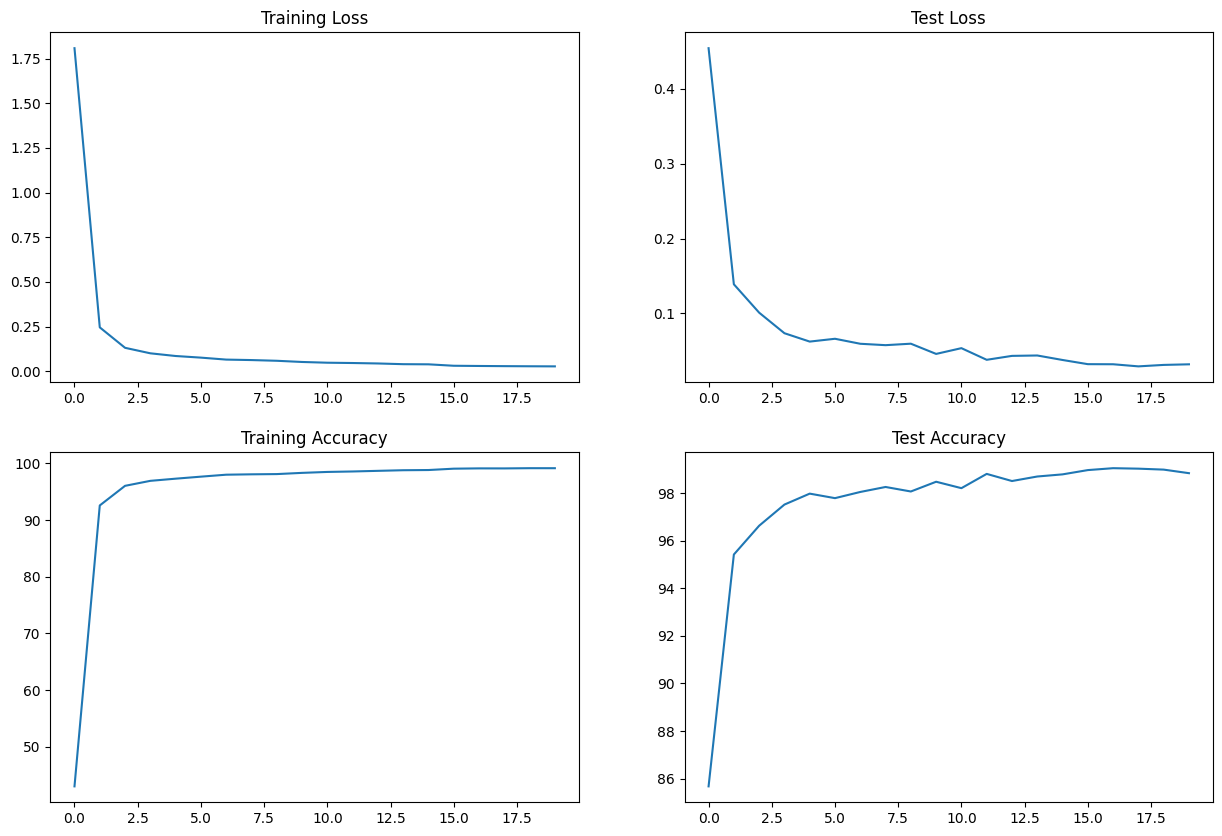

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
